In [1]:
import os
import sys
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from model.CNN_model import CNNTextClassifier
from model.BiLSTM_model import BiLSTMModel
from language_model import train, evaluate
from evaluation import class_accuracy, class_f1_score,\
    class_wise_precision_recall, plot_confusion_matrix
from utils import tokenize, remove_stopwords, stemming, fit_tokenizer, plot_loss_acc,\
    pad_sequence, PandasDataset, get_batched_data, get_class_weights, grid_search

# Data Preparation

In [2]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.sample(10)

,text,label
246581,i feel empty for lack of a better word,0
342841,i feel a little insulted that as readers we re...,3
360412,i see what youre doing there copping a feel wh...,3
35290,i alternate between feeling sympathetic toward...,2
143945,i promised to protect her like what he said ye...,1
245326,i start shaking and feel cold,3
54441,i feel accepted and appreciated by my teammate...,1
71733,i probably didnt even need to write this post ...,0
12003,i feel miserable tearful and generally awful,0
58029,i am making she feels assured that i am there ...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
# data.duplicated().sum()
data.drop_duplicates(inplace= True)

### Tokenize, stem and remove stopwords 

In [5]:
data['tokens_stemm'] = data['text'].apply(tokenize).apply(remove_stopwords).apply(stemming)
# data['tokens_stemm'] = data['tokens']
data = data[~(data['tokens_stemm'].apply(len) == 0)]
data.sample(10)

,text,label,tokens_stemm
33973,i do feel that running is a divine experience ...,1,"[feel, run, divin, experi, expect, type, spiri..."
260325,i was feeling a bit restless,4,"[feel, bit, restless]"
290134,i feel really appalled and terribly sad that s...,3,"[feel, realli, appal, terribl, sad, someon, wo..."
115512,i could not wait to come home and journal abou...,1,"[could, wait, come, home, journal, feel, divin..."
205621,i had glanced through grey at target feeling a...,1,"[glanc, grey, target, feel, littl, excit, time..."
217505,i feel isnt resolved very well by the end of t...,1,"[feel, isnt, resolv, well, end, film, worth]"
125872,i feel i must mention it here if somebody shou...,0,"[feel, must, mention, somebodi, happen, kill, ..."
366375,id like to avoid the spread jumps and a lower ...,3,"[id, like, avoid, spread, jump, lower, frame, ..."
215314,i attended the march th school board meeting a...,0,"[attend, march, th, school, board, meet, left,..."
23819,im feeling emotional resonance with caleb caud...,0,"[im, feel, emot, reson, caleb, caudl, paint, a..."


### Split data into train and test sets. Calculate class weights.

In [6]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# Calculate class weights
class_weights = get_class_weights(data['label'])
print(f"Class Weights : {class_weights}")

train_data = pd.concat((x_train,y_train), axis=1).reset_index()
test_data = pd.concat((x_test,y_test), axis=1).reset_index()
print(f"Train size: {len(train_data)}\tTest size: {len(test_data)}")

Class Weights : tensor([0.5732, 0.4926, 2.0104, 1.2118, 1.4551, 4.6361])
Train size: 332886	Test size: 83222


### Fit tokenizer

In [7]:
# tokenizer = fit_tokenizer(data['tokens_stemm'])
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print("Tokenizer saved to file.")
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Pad the sequences to have uniform length. Batch the data for training.

In [8]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
print("Data prepared for model!")
train_dataset = PandasDataset(train_data)
test_dataset = PandasDataset(test_data)
train_batched = get_batched_data(train_dataset, batch_size= 256)
test_batched = get_batched_data(test_dataset, batch_size= 64)

Data prepared for model!


# CNN

### Initialise the model

In [13]:
model = CNNTextClassifier()
print(model)

CNNTextClassifier(
  (embedding): Embedding(52000, 32)
  (conv): Sequential(
    (0): Conv1d(32, 24, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=98, stride=98, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (dense): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [14]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1666830


### Train the model

In [15]:
# parameter_configs = {
#     'embedding_dim': [32],
#     'num_filters': [24],
#     'kernel_size': [3],
#     'hidden_units': [16], 
#     }
# parameter_configurations = grid_search(parameter_configs)

In [16]:
model, losses, accs = train(model, train_batched, num_epochs= 4,
                            lr= 0.001, lr_floor= 0.00001,
                            class_weights= class_weights)

  0%|          | 0/1041 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 1/1041 [00:00<03:52,  4.47it/s]

  0%|          | 1/1041 [00:00<02:17,  7.54it/s]

Epoch 1/4, Iter 1/4 Train Loss: 1.0747, Train Accuracy: 48.934%, Val Accuracy: 79.532%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/4, Iter 2/4 Train Loss: 0.7110, Train Accuracy: 67.458%, Val Accuracy: 89.055%


  0%|          | 1/1041 [00:00<02:16,  7.61it/s]

Epoch 1/4, Iter 3/4 Train Loss: 0.5552, Train Accuracy: 74.845%, Val Accuracy: 90.058%


  0%|          | 1/1041 [00:00<02:05,  8.27it/s]

Epoch 1/4, Iter 4/4 Train Loss: 0.4700, Train Accuracy: 78.717%, Val Accuracy: 90.630%


  0%|          | 1/1041 [00:00<02:14,  7.74it/s]

Epoch 1/4, Iter 5/4 Train Loss: 0.4162, Train Accuracy: 81.096%, Val Accuracy: 90.618%


  0%|          | 1/1041 [00:00<02:22,  7.29it/s]

Epoch 2/4, Iter 1/4 Train Loss: 0.1911, Train Accuracy: 90.873%, Val Accuracy: 91.245%


  0%|          | 1/1041 [00:00<02:25,  7.15it/s]

Epoch 2/4, Iter 2/4 Train Loss: 0.1878, Train Accuracy: 90.963%, Val Accuracy: 90.886%


  0%|          | 1/1041 [00:00<02:17,  7.58it/s]

Epoch 2/4, Iter 3/4 Train Loss: 0.1853, Train Accuracy: 91.018%, Val Accuracy: 91.046%


  0%|          | 1/1041 [00:00<02:37,  6.59it/s]

Epoch 2/4, Iter 4/4 Train Loss: 0.1825, Train Accuracy: 91.102%, Val Accuracy: 91.206%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/4, Iter 5/4 Train Loss: 0.1801, Train Accuracy: 91.171%, Val Accuracy: 91.601%


  0%|          | 1/1041 [00:00<02:30,  6.91it/s]

Epoch 3/4, Iter 1/4 Train Loss: 0.1655, Train Accuracy: 91.585%, Val Accuracy: 91.353%


  0%|          | 1/1041 [00:00<02:18,  7.48it/s]

Epoch 3/4, Iter 2/4 Train Loss: 0.1644, Train Accuracy: 91.612%, Val Accuracy: 91.814%


  0%|          | 1/1041 [00:00<02:19,  7.47it/s]

Epoch 3/4, Iter 3/4 Train Loss: 0.1631, Train Accuracy: 91.673%, Val Accuracy: 91.864%


  0%|          | 1/1041 [00:00<02:18,  7.49it/s]

Epoch 3/4, Iter 4/4 Train Loss: 0.1616, Train Accuracy: 91.729%, Val Accuracy: 91.847%


  0%|          | 1/1041 [00:00<02:15,  7.69it/s]

Epoch 3/4, Iter 5/4 Train Loss: 0.1602, Train Accuracy: 91.790%, Val Accuracy: 92.032%


  0%|          | 1/1041 [00:00<02:33,  6.80it/s]

Epoch 4/4, Iter 1/4 Train Loss: 0.1517, Train Accuracy: 92.083%, Val Accuracy: 92.220%


  0%|          | 1/1041 [00:00<02:18,  7.53it/s]

Epoch 4/4, Iter 2/4 Train Loss: 0.1508, Train Accuracy: 92.150%, Val Accuracy: 92.137%


  0%|          | 1/1041 [00:00<02:12,  7.87it/s]

Epoch 4/4, Iter 3/4 Train Loss: 0.1498, Train Accuracy: 92.196%, Val Accuracy: 92.066%


  0%|          | 1/1041 [00:00<02:13,  7.77it/s]

Epoch 4/4, Iter 4/4 Train Loss: 0.1490, Train Accuracy: 92.226%, Val Accuracy: 92.646%


100%|██████████| 1041/1041 [02:03<00:00,  8.43it/s]


Epoch 4/4, Iter 5/4 Train Loss: 0.1481, Train Accuracy: 92.262%, Val Accuracy: 92.394%


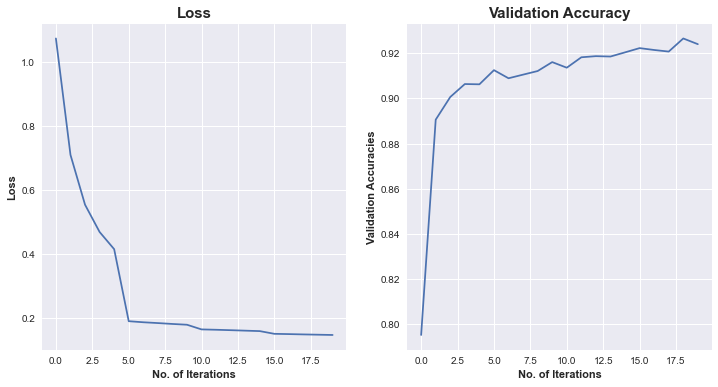

In [17]:
# plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= True)

  0%|          | 3/1301 [00:00<00:47, 27.39it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:23<00:00, 55.25it/s]


Average acccuracy: 84.88%
Average F1: 87.39%


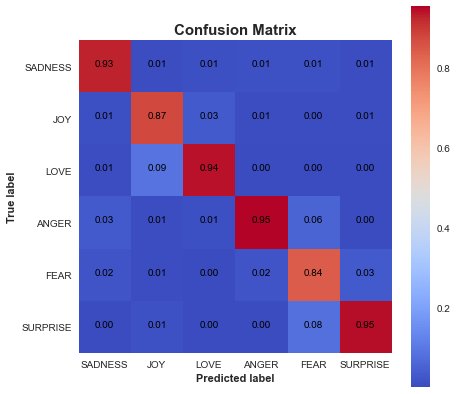

In [18]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= True)

In [19]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 84.88%
Average F1: 87.39%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.974013,0.949000,0.925240,0.974013
1,Joy,0.976388,0.922377,0.874029,0.976388
2,Love,0.695204,0.800275,0.942760,0.695204
3,Anger,0.870666,0.910793,0.954796,0.870666
4,Fear,0.886193,0.862556,0.840146,0.886193
5,Surprise,0.690204,0.798515,0.947145,0.690204


In [20]:
torch.save(model, f= "../model/cnn.pth")

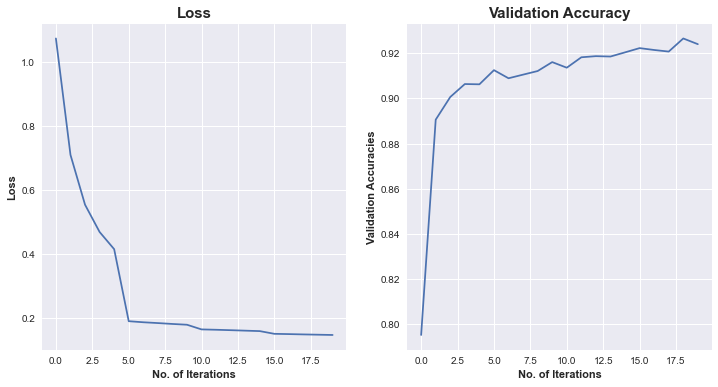

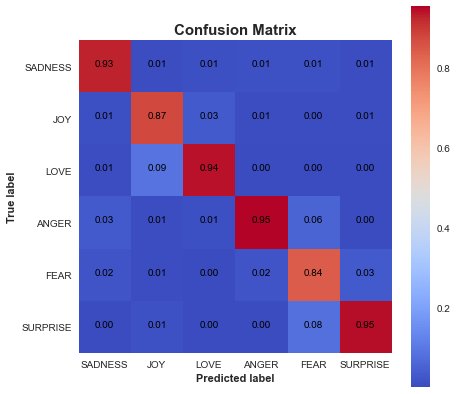

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, AnyStr
from itertools import product

def plot_loss_acc(loss: List, accs: List, modelname: AnyStr, plot = False) -> None:
    plt.style.use("seaborn")
    fig, axes = plt.subplots(1,2, figsize= (12,6))
    num_of_items = len(loss)
    sns.lineplot(ax= axes[0], x= range(num_of_items), y= loss)
    sns.lineplot(ax= axes[1], x= range(num_of_items), y= accs)
    
    axes[0].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[1].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[0].set_ylabel("Loss", fontdict={"fontweight":"bold"})
    axes[1].set_ylabel("Validation Accuracies", fontdict={"fontweight":"bold"})
    axes[0].set_title("Loss", fontdict={"fontweight":"bold", "fontsize":15})
    axes[1].set_title("Validation Accuracy", fontdict={"fontweight":"bold", "fontsize":15})
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            fig.savefig(fname= "../images/bilstm_loss_acc.png", dpi=300)
        elif modelname == 'cnn':
            fig.savefig(fname= "../images/cnn_loss_acc.png", dpi=300)

def plot_confusion_matrix(conf_matrix, modelname, plot= False):
    labels = {0: "SADNESS", 1: "JOY", 2: "LOVE", 3: "ANGER", 4: "FEAR", 5: "SURPRISE"}
    plt.style.use("seaborn")
    plt.figure(figsize=(7,7))
    norm_conf_mat = np.divide(conf_matrix, np.sum(conf_matrix, axis= 0))
    plt.imshow(norm_conf_mat, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    
    plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    
    fmt = '.2f'
    for i, j in product(range(norm_conf_mat.shape[0]), range(norm_conf_mat.shape[1])):
        plt.text(j, i, format(norm_conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.grid(False)
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            plt.savefig(fname= "../images/bilstm_confmat.png", dpi=300)
        elif modelname == 'cnn':
            plt.savefig(fname= "../images/cnn_confmat.png", dpi=300)
            
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= False)

# BiLSTM

### Initialize the model

In [29]:
model = BiLSTMModel(embedding_dim=32, hidden_size= 16, p= 0.2)
print(model)

BiLSTMModel(
  (embedding): Embedding(52000, 32)
  (lstm): LSTM(32, 16, bidirectional=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [30]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1671094


### Train the model

In [31]:
model, losses, accs = train(model, train_batched, num_epochs= 4,
                            lr= 0.0005, lr_floor= 0.00001,
                            class_weights= class_weights)

  0%|          | 0/1041 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


  0%|          | 1/1041 [00:00<02:43,  6.34it/s]

Epoch 1/4, Iter 1/4 Train Loss: 1.5617, Train Accuracy: 27.524%, Val Accuracy: 36.623%


  0%|          | 1/1041 [00:00<03:06,  5.58it/s]

Epoch 1/4, Iter 2/4 Train Loss: 1.6825, Train Accuracy: 23.019%, Val Accuracy: 29.099%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/4, Iter 3/4 Train Loss: 1.7189, Train Accuracy: 21.028%, Val Accuracy: 13.517%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/4, Iter 4/4 Train Loss: 1.7371, Train Accuracy: 21.493%, Val Accuracy: 13.749%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/4, Iter 5/4 Train Loss: 1.7481, Train Accuracy: 20.508%, Val Accuracy: 11.273%


  0%|          | 1/1041 [00:00<02:41,  6.45it/s]

Epoch 2/4, Iter 1/4 Train Loss: 0.6991, Train Accuracy: 69.422%, Val Accuracy: 80.756%


  0%|          | 1/1041 [00:00<02:51,  6.05it/s]

Epoch 2/4, Iter 2/4 Train Loss: 0.5521, Train Accuracy: 76.419%, Val Accuracy: 85.454%


  0%|          | 1/1041 [00:00<02:53,  5.99it/s]

Epoch 2/4, Iter 3/4 Train Loss: 0.4723, Train Accuracy: 79.894%, Val Accuracy: 87.427%


  0%|          | 1/1041 [00:00<02:41,  6.45it/s]

Epoch 2/4, Iter 4/4 Train Loss: 0.4227, Train Accuracy: 81.954%, Val Accuracy: 88.664%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/4, Iter 5/4 Train Loss: 0.3880, Train Accuracy: 83.359%, Val Accuracy: 88.875%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 3/4, Iter 1/4 Train Loss: 0.2855, Train Accuracy: 88.269%, Val Accuracy: 89.333%


  0%|          | 1/1041 [00:00<03:08,  5.53it/s]

Epoch 3/4, Iter 2/4 Train Loss: 0.2548, Train Accuracy: 89.073%, Val Accuracy: 90.001%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 3/4, Iter 3/4 Train Loss: 0.2399, Train Accuracy: 89.461%, Val Accuracy: 90.395%


  0%|          | 1/1041 [00:00<02:56,  5.91it/s]

Epoch 3/4, Iter 4/4 Train Loss: 0.2301, Train Accuracy: 89.728%, Val Accuracy: 90.668%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 3/4, Iter 5/4 Train Loss: 0.2229, Train Accuracy: 89.922%, Val Accuracy: 91.066%


  0%|          | 1/1041 [00:00<02:49,  6.14it/s]

Epoch 4/4, Iter 1/4 Train Loss: 0.2342, Train Accuracy: 89.886%, Val Accuracy: 90.736%


  0%|          | 1/1041 [00:00<02:51,  6.06it/s]

Epoch 4/4, Iter 2/4 Train Loss: 0.2098, Train Accuracy: 90.470%, Val Accuracy: 91.123%


  0%|          | 1/1041 [00:00<02:37,  6.60it/s]

Epoch 4/4, Iter 3/4 Train Loss: 0.1994, Train Accuracy: 90.726%, Val Accuracy: 91.327%


  0%|          | 1/1041 [00:00<02:45,  6.27it/s]

Epoch 4/4, Iter 4/4 Train Loss: 0.1932, Train Accuracy: 90.894%, Val Accuracy: 91.417%


100%|██████████| 1041/1041 [02:40<00:00,  6.48it/s]


Epoch 4/4, Iter 5/4 Train Loss: 0.1885, Train Accuracy: 91.018%, Val Accuracy: 91.327%


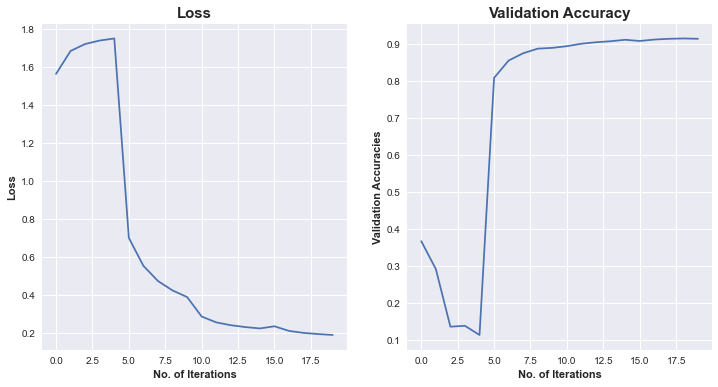

In [32]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= True)

  0%|          | 4/1301 [00:00<00:43, 29.89it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:28<00:00, 45.80it/s]


Average acccuracy: 84.48%
Average F1: 87.29%


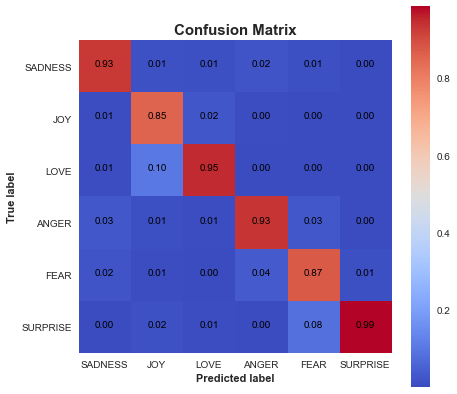

In [33]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= True)

In [34]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 84.48%
Average F1: 87.29%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.964956,0.947860,0.931360,0.964956
1,Joy,0.982838,0.912187,0.851013,0.982838
2,Love,0.672847,0.787949,0.950559,0.672847
3,Anger,0.894175,0.912663,0.931932,0.894175
4,Fear,0.874016,0.872184,0.870361,0.874016
5,Surprise,0.679874,0.804582,0.985318,0.679874


In [35]:
torch.save(model,f= "../model/bilstm.pth")

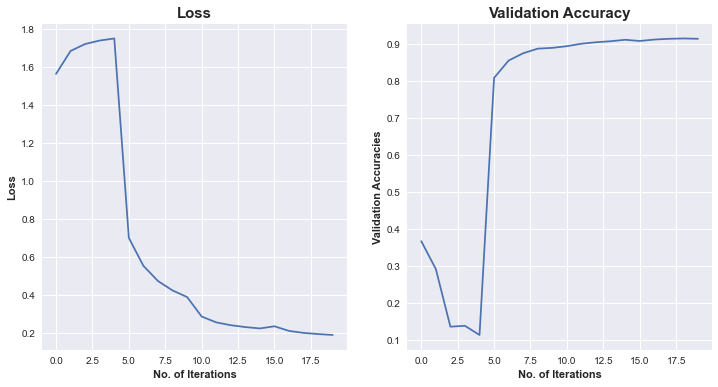

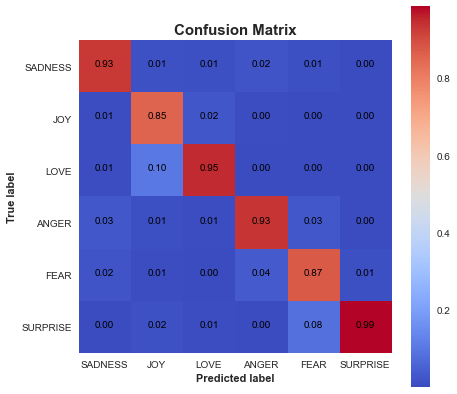

In [36]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= False)

# Model Comparison

In [37]:
cnn_model = torch.load("../model/cnn.pth")
bilstm_model = torch.load("../model/bilstm.pth")
criterion = nn.CrossEntropyLoss()

In [38]:
test_batched_comparison = get_batched_data(test_dataset, batch_size= 512)
len(test_batched_comparison)

163

In [39]:
def get_loss(model, loss_function, test_dataloader):
    loss_list = []
    model.eval()
    for batch in tqdm(test_dataloader):
        inputs = batch['padded']
        labels = batch['label']
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        loss_list.append(loss.item())
        
    return loss_list

In [40]:
cnn_loss = get_loss(cnn_model, criterion, test_batched_comparison)

100%|██████████| 163/163 [00:18<00:00,  8.63it/s]


In [41]:
bilstm_loss = get_loss(bilstm_model, criterion, test_batched_comparison)

100%|██████████| 163/163 [00:19<00:00,  8.21it/s]


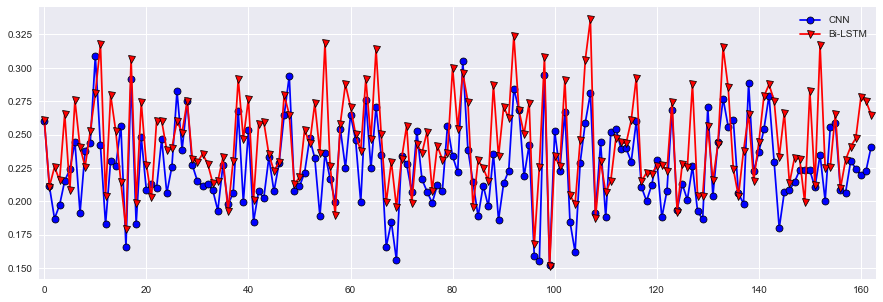

In [42]:
fig, axes = plt.subplots(figsize= (15,5))

sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= cnn_loss, color='blue', marker='o', markeredgecolor= 'k', label= "CNN")
sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= bilstm_loss, color='red', marker='v', markeredgecolor= 'k', label= "Bi-LSTM")
axes.set_xlim(-1,163);

In [43]:
print(f"CNN Accuracy - Mean: {np.mean(cnn_loss):.4f}, Std: {np.std(cnn_loss):.4f}")
print(f"Bi-LSTM Accuracy - Mean: {np.mean(bilstm_loss):.4f}, Std: {np.std(bilstm_loss):.4f}")

CNN Accuracy - Mean: 0.2253, Std: 0.0314
Bi-LSTM Accuracy - Mean: 0.2438, Std: 0.0338


In [45]:
delta = [np.abs(cnn_loss[i] - bilstm_loss[i]) for i in range(len(test_batched_comparison))]
Delta = np.mean(delta)
Var = np.mean([(delta[i]- Delta)**2 for i in range(len(test_batched_comparison))])
print(f"Test Statistic T = {np.round(Delta / np.sqrt(Var),2)}")
print(f"Corresponding p-value (lowest alpha value) = {0.1936}")

Test Statistic T = 1.3
Corresponding p-value (lowest alpha value) = 0.1936


#### This implied that we can say with 80% confidence, the $H_0$: $R_{S_{CNN}}$ = $R_{S_{Bi-LSTM}}$ model perform the same should be rejected.

# ROC Curve

In [46]:
from sklearn.metrics import roc_curve, auc

In [47]:
def plot_roc_curve(model, test_loader, num_classes=6):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    emotion_map = {0:"sadness", 1:"joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
    y_true = []
    y_probs = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['padded'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.extend(probabilities)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {emotion_map[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

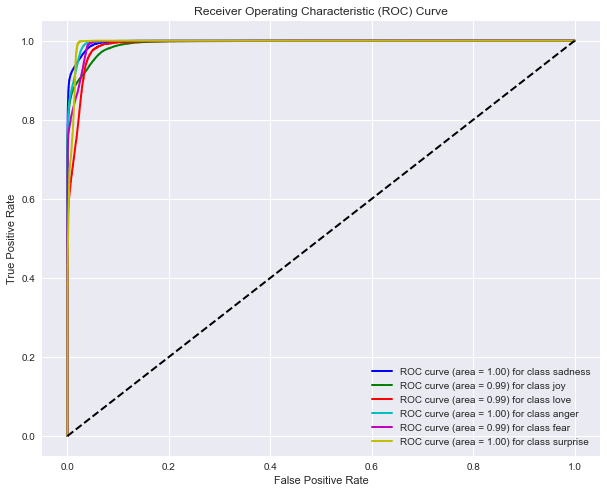

In [48]:
plot_roc_curve(cnn_model, test_batched_comparison)

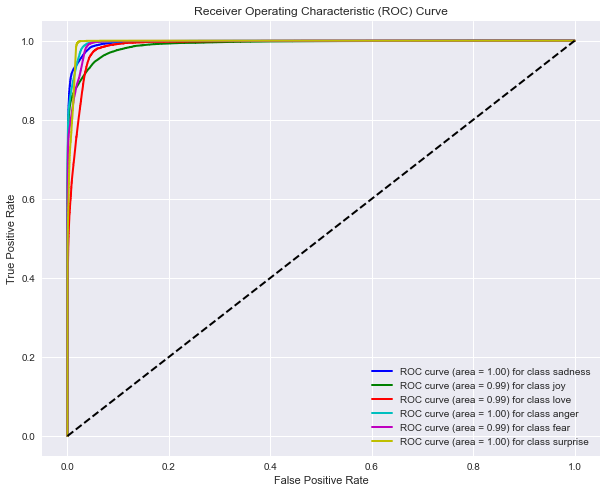

In [49]:
plot_roc_curve(bilstm_model, test_batched_comparison)